In [12]:
# pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/e2/7b/8c1b410cd0604cee9a167a19f7e1746f5b92ae7d02ad574ab560b73c5a48/xgboost-2.1.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 330.3 kB/s eta 0:06:19
   ---------------------------------------- 0.0/124.9 MB 495.5 kB/s eta 0:04:12
   ---------------------------------------- 0.2/124.9 MB 1.3 MB/s eta 0:01:35
   ---------------------------------------- 0.3/124.9 MB 1.9 MB/s eta 0:01:06
   ---------------------------------------- 0.4/124.9 MB 2.2 MB/s eta 0:00:57
   ---------------------------------------- 0.5/124.9 MB 2.2 MB/s eta 0:00:56
   ---------------------------------------- 0.7/124.9 MB 2.6 MB/s eta 0:00:48
   ---------------------------------------- 0.9/124.9 MB 2.8 MB/s eta 0:00:45
   ---------------------------------------- 1.1/124.9 MB 3.2 MB/s eta 0:00:40
   ---------------

In [1]:
import sys
import os

# add the parent directory ('BNetzA') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np

from models import *
from Data_Preprocessing.data_preprocessing import *

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

pd.set_option('display.float_format', '{:.4f}'.format)

# Loading Datasets

In [3]:
# load Data
path_to_excel = "../data/EVS4_20140118_dataV9.xlsx"
df = load_data(path_to_excel, sheet_name="DatasetV9")

In [4]:
# df_test_list = [df_test, df_test_xlog, df_test_xlog_ylog, df_test_ylog, df_test_agg, df_test_agg_log, df_test_non_agg, df_test_group_agg]
# baseline, xlog, xlog ylog, ylog, agg, agg ylog, non agg, group agg
# missing: agg xlog, agg xlog ylog
# missing: non agg xlog, non agg xlog ylog, non agg ylog
# missing: group agg xlog, group agg xlog ylog, group agg ylog

In [5]:
outcome_variables = ["cTOTEXn", "cTOTEXn", "cTOTEXn_log", "cTOTEXn_log", "cTOTEXn", "cTOTEXn_log", "cTOTEXn", "cTOTEXn"]
names = ["Baseline", "XLog", "XLog YLog", "YLog", "Aggregates Only", "Aggregates Only YLog", "Disaggregates Only", "Aggregates N1-4 N5-7"]
outcome_transformation = ["None", "None", "log", "log", "None", "log", "None", "None"]
random_states = [39, 40, 41, 42, 43]
columns = ["Model", "Training RMSE", "Training MAE", "Training MAPE", 
           "Testing RMSE", "Testing MAE", "Testing MAPE"]

# Lasso Regression

In [8]:
lasso_results = pd.DataFrame(columns=columns)
lasso_models = []
lasso_vips = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)
    for i in range(len(df_train_list)):
        lasso_result, lasso_model, lasso_vip = lasso_regression(df_train_list[i], df_test_list[i], outcome_variables[i], f"Lasso {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
        lasso_results = pd.concat([lasso_results, lasso_result], axis=0, ignore_index=True)
        lasso_models.append(lasso_model)
        lasso_vips.append(lasso_vip)

lasso_results.loc[:, lasso_results.columns != 'Model'] = lasso_results.loc[:, lasso_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
lasso_results_df = lasso_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
lasso_results_df

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Lasso Aggregates Only YLog,19509173.4220,7579512.9960,0.1240,11268863.2300,5562088.2800,0.1400
6,Lasso XLog YLog,20123969.0380,7400527.3200,0.1220,15132882.6880,6881961.5580,0.1480
1,Lasso Aggregates Only,7583134.1940,4640771.0300,0.1740,17908963.3640,7210410.5920,0.1960
4,Lasso Disaggregates Only,4387758.6500,2950621.7080,0.1460,16269428.3820,7617384.2360,0.3640
3,Lasso Baseline,4451456.6160,2969861.2360,0.1460,16244300.1740,7705064.8980,0.3680
0,Lasso Aggregates N1-4 N5-7,5382050.9060,3731400.3880,0.1660,15150573.6480,7532817.4960,0.4240
7,Lasso YLog,238548674.4180,31717017.5340,0.3220,1519404205.0400,349358998.6680,0.8500
5,Lasso XLog,72088678.5860,37785655.4460,1.6920,61913800.8180,36692748.2300,2.1400


In [142]:
lasso_xlog_ylog_vips = [lasso_vips[2], lasso_vips[10], lasso_vips[18], lasso_vips[26], lasso_vips[34]] 
lasso_xlog_ylog_frequency = variable_frequency(lasso_xlog_ylog_vips, "Lasso XLog YLog")
lasso_xlog_ylog_stable = lasso_xlog_ylog_frequency[lasso_xlog_ylog_frequency["Lasso XLog YLog"] > 3]["Variable"].unique()
lasso_xlog_ylog_frequency[lasso_xlog_ylog_frequency["Lasso XLog YLog"] > 3]

,Variable,Lasso XLog YLog
0,yEnergy.losses.tot,5
1,yInstalledPower.other.tot,5
2,yNet.length.excl.house.tot,5
3,yEnergy.delivered.N1357.sum,5
4,ySubstations.N4,5
5,yArea.other.N7,4
6,ySubstations.own.N4,4
7,yPeakload.max,4
8,yPeakload.injection.N6,4


In [140]:
lasso_agg_log_vips = [lasso_vips[5], lasso_vips[13], lasso_vips[21], lasso_vips[29], lasso_vips[37]] 
lasso_agg_log_frequency = variable_frequency(lasso_agg_log_vips, "Lasso Agg YLog")
lasso_agg_log_stable = lasso_agg_log_frequency[lasso_agg_log_frequency["Lasso Agg YLog"] > 3]["Variable"].unique()
lasso_agg_log_frequency[lasso_agg_log_frequency["Lasso Agg YLog"] > 3]

,Variable,Lasso Agg YLog
0,yEnergy.losses.tot,5
1,yNet.length.excl.house.tot,5
2,yInstalledPower.other.tot,5
3,yInstalledPower.KWKG.other.tot,5
4,yEnergy.delivered.N1357.sum,5
5,yMeters.over10MWh.RPM.tot,4
6,yInjection.tot,4
7,yEnergy.delivered.net.N67.sum,4
8,yEnergy.delivered.tot,4
9,yMeters.active.tot,4


# Linear Regression with selected Features from Lasso¶

In [14]:
lr_results = pd.DataFrame(columns=columns)
lr_models = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)
    for i in range(len(df_train_list)):
        lr_result, lr_model= lasso_feature_selection_linear_regression(df_train_list[i], df_test_list[i], outcome_variables[i], f"Linear Regresion {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
        lr_results = pd.concat([lr_results, lr_result], axis=0, ignore_index=True)
        lr_models.append(lr_model)

lr_results.loc[:, lr_results.columns != 'Model'] = lr_results.loc[:, lr_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
lr_results_df = lr_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
lr_results_df

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Linear Regresion Aggregates Only YLog,15662174.8340,6470256.8480,0.1200,10119945.7280,5421080.0660,0.1380
6,Linear Regresion XLog YLog,15695991.1580,6450477.1820,0.1160,14841106.8660,6892647.4480,0.1500
1,Linear Regresion Aggregates Only,6968612.1220,4517576.9640,0.1840,16672876.6480,6854655.0280,0.2040
4,Linear Regresion Disaggregates Only,3087245.3840,2234400.2060,0.1360,36073805.1720,14134950.3240,0.3700
3,Linear Regresion Baseline,3013376.3480,2182353.8140,0.1400,31828459.8400,12707307.4880,0.3940
0,Linear Regresion Aggregates N1-4 N5-7,4094861.7000,3036755.8340,0.1700,16060904.9740,8039822.2140,0.4480
7,Linear Regresion YLog,35254376.8480,11705541.8580,0.2320,2970443916.6660,674762907.3500,1.1100
5,Linear Regresion XLog,63012231.9180,37332414.5620,1.8200,84939751.7220,46865510.8120,2.8300


# Random Forest Regression

In [27]:
rf_results = pd.DataFrame(columns=columns)
rf_models = []
rf_vips = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)
    for i in range(len(df_train_list)):
        rf_result, rf_model, rf_vip = random_forest_regression(df_train_list[i], df_test_list[i], outcome_variables[i], f"Random Forest {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
        rf_results = pd.concat([rf_results, rf_result], axis=0, ignore_index=True)
        rf_models.append(rf_model)
        rf_vips.append(rf_vip)

rf_results.loc[:, rf_results.columns != 'Model'] = rf_results.loc[:, rf_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
rf_results_df = rf_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
rf_results_df

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
6,Random Forest XLog YLog,19134934.1460,4903620.0280,0.0600,32468675.7160,10972026.8180,0.1760
7,Random Forest YLog,20204170.5080,5140860.4460,0.0600,31763949.2860,10782847.6540,0.1780
2,Random Forest Aggregates Only YLog,19972940.5420,4928059.3220,0.0600,31137574.2240,10251750.1800,0.1860
1,Random Forest Aggregates Only,15751245.6360,4346582.2560,0.0720,30678835.8600,10800411.9820,0.2180
3,Random Forest Baseline,15309123.3900,4301444.3720,0.0700,31011846.2520,10879545.2560,0.2300
5,Random Forest XLog,14555804.5060,4205995.5220,0.0700,32649680.9140,11256803.3320,0.2300
0,Random Forest Aggregates N1-4 N5-7,15494560.2020,4429694.9580,0.0660,32930711.2300,11181104.2840,0.2440
4,Random Forest Disaggregates Only,17973736.4740,4643067.4300,0.0760,38131893.8420,13049602.4240,0.2900


In [71]:
rf_agg_log_vips = [rf_vips[5], rf_vips[13], rf_vips[21], rf_vips[29], rf_vips[37]] 
rf_agg_log_frequency = variable_frequency(rf_agg_log_vips, "Random Forest Aggregates Only YLog")
rf_agg_log_stable = rf_agg_log_frequency[rf_agg_log_frequency["Random Forest Aggregates Only YLog"] > 2]["Variable"].unique()
rf_agg_log_frequency[rf_agg_log_frequency["Random Forest Aggregates Only YLog"] > 2]

,Variable,Random Forest Aggregates Only YLog
0,yEnergy.delivered.net.N5to7.sum,5
1,yEnergy.delivered.tot,5
2,yMeters.all.tot,5
3,yEnergy.delivered.net.tot,5
4,yTransformers.tot,5
5,yEnergy.losses.tot,5
6,yEnergy.delivered.N1357.sum,5
7,yMeters.read.noncp.sum,5
8,yMeters.active.tot,5
9,yInjection.tot,5


In [15]:
rf_results.loc[:, rf_results.columns != 'Model'] = rf_results.loc[:, rf_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
rf_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
7,Random Forest YLog,36693302.4640,7167030.3120,0.0700,39793393.2180,12615968.8700,0.1820
6,Random Forest XLog YLog,36467920.7900,7086270.6680,0.0700,38545130.3440,12294038.1220,0.1860
2,Random Forest Aggregates Only YLog,37720341.4260,7369140.6220,0.0720,37824967.0540,11750373.7020,0.1920
0,Random Forest Aggregates N1-4 N5-7,29553159.6620,6340270.4580,0.0800,41580339.8440,13574560.1200,0.2220
1,Random Forest Aggregates Only,29774959.3140,6523046.7580,0.0820,38484881.3920,12521322.5200,0.2220
3,Random Forest Baseline,29180181.5740,6122334.1160,0.0800,36600651.9800,12138023.8520,0.2320
5,Random Forest XLog,29336375.2420,6246264.0060,0.0820,37443336.8180,12519869.8480,0.2340
4,Random Forest Disaggregates Only,28743123.8560,6035507.3100,0.0840,37138590.8720,12468855.2040,0.2840


# Decision Tree

In [29]:
dt_results = pd.DataFrame(columns=columns)
dt_models = []
dt_vips = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)
    for i in range(len(df_train_list)):
        dt_result, dt_model, dt_vip = decision_tree_regression(df_train_list[i], df_test_list[i], outcome_variables[i], f"Decision Tree {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
        dt_results = pd.concat([dt_results, dt_result], axis=0, ignore_index=True)
        dt_models.append(dt_model)
        dt_vips.append(dt_vip)

dt_results.loc[:, dt_results.columns != 'Model'] = dt_results.loc[:, dt_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
dt_results_df = dt_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
dt_results_df

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
3,Decision Tree Baseline,14732790.0080,3109712.3300,0.0360,30017159.0520,11046364.9360,0.2160
5,Decision Tree XLog,14653850.4780,3098652.2000,0.0340,32852911.8800,11860650.1600,0.2180
4,Decision Tree Disaggregates Only,5082944.6140,1144066.4880,0.0240,30410442.1560,10751974.8340,0.2220
7,Decision Tree YLog,28298985.5660,6019625.5460,0.0560,53822603.4780,17095497.8600,0.2440
2,Decision Tree Aggregates Only YLog,29351417.3700,6708681.1120,0.0640,66000628.9300,21318852.9340,0.2460
1,Decision Tree Aggregates Only,16350463.3160,4012843.7580,0.0600,34796633.5400,12521636.3640,0.2580
6,Decision Tree XLog YLog,33598548.2400,7324825.7300,0.0620,87157855.3420,28943622.3480,0.2860
0,Decision Tree Aggregates N1-4 N5-7,21241057.6400,5002626.5860,0.0580,52750723.3240,18939836.9440,0.3200


In [317]:
dt_baseline_vips = [dt_vips[0], dt_vips[8], dt_vips[16], dt_vips[24], dt_vips[32]] 
dt_baseline_frequency = variable_frequency(dt_baseline_vips, "Decision Tree Baseline")
dt_baseline_stable = dt_baseline_frequency[dt_baseline_frequency["Decision Tree Baseline"] > 1]["Variable"].unique()
dt_baseline_frequency[dt_baseline_frequency["Decision Tree Baseline"] > 1]

,Variable,Decision Tree Baseline
0,yEnergy.delivered.N7,3
1,yPeakload.injection.max,3
2,yPeakload.injection.N6,2
3,yEnergy.delivered.net.N5to7.sum,2
4,yTransformers.N6,2
5,yEnergy.delivered.N5,2
6,yPeakload.injection.N3,2
7,rInjection.generation.per.point.N6,2
8,yPeakload.injection.N4,2


# Cluster-Based Modeling

In [31]:
cluster_results = pd.DataFrame(columns=columns)
cluster_models_c0 = []
cluster_models_c1 = []

outcome_variables_cbm = ["cTOTEXn", "cTOTEXn_log"]
names_cbm = ["Baseline", "YLog"]
outcome_transformation_cbm = ["None", "log"]
indices = [0, 3]

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)
    for i in range(len(outcome_transformation_cbm)):
        cluster_result, model_c0, model_c1 = cluster_based_modeling(df_train_list[indices[i]], df_test_list[indices[i]], outcome_variables_cbm[i], f"Cluster-Based Modeling {names_cbm[i]}", outcome_transformation = outcome_transformation_cbm[i], random_state = random_state)
        cluster_results = pd.concat([cluster_results, cluster_result], axis=0, ignore_index=True)
        cluster_models_c0.append(model_c0)
        cluster_models_c1.append(model_c1)

cluster_results.loc[:, cluster_results.columns != 'Model'] = cluster_results.loc[:, cluster_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
cluster_results_df = cluster_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
cluster_results_df

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Cluster-Based Modeling Baseline_Random Forest_...,4754003.2400,2640416.4700,0.0900,13571233.7900,5795520.6600,0.1300
4,Cluster-Based Modeling YLog_Random Forest_Rand...,13595760.4500,4069552.6200,0.0600,97656319.3500,25657539.5700,0.1800
3,Cluster-Based Modeling YLog_Lasso_Random Forest,19109230.9025,5332817.5150,0.1075,17904496.4100,8284606.6000,0.2075
0,Cluster-Based Modeling Baseline_Lasso_Lasso,3557628.1850,2283322.3950,0.1000,17393501.4950,8130304.4800,0.2100
1,Cluster-Based Modeling Baseline_Lasso_Random F...,17257074.4100,4730757.6250,0.0950,8629992.1350,4629656.3850,0.2700


Due to very unstable best performing model, this approach is not anymore feasible for the use case. In 10 different runs, 5 different models have emerged.

# Summary Results

## Evaluation Metrics

In [257]:
# full tablle
combined_all = pd.concat([lasso_results_df, lr_results_df, rf_results_df, dt_results_df], axis=0)
combined_all.sort_values(by=["Testing MAPE", "Testing RMSE"], ascending=True)

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Linear Regresion Aggregates Only YLog,15662174.8340,6470256.8480,0.1200,10119945.7280,5421080.0660,0.1380
2,Lasso Aggregates Only YLog,19509173.4220,7579512.9960,0.1240,11268863.2300,5562088.2800,0.1400
6,Lasso XLog YLog,20123969.0380,7400527.3200,0.1220,15132882.6880,6881961.5580,0.1480
6,Linear Regresion XLog YLog,15695991.1580,6450477.1820,0.1160,14841106.8660,6892647.4480,0.1500
6,Random Forest XLog YLog,19134934.1460,4903620.0280,0.0600,32468675.7160,10972026.8180,0.1760
7,Random Forest YLog,20204170.5080,5140860.4460,0.0600,31763949.2860,10782847.6540,0.1780
2,Random Forest Aggregates Only YLog,19972940.5420,4928059.3220,0.0600,31137574.2240,10251750.1800,0.1860
1,Lasso Aggregates Only,7583134.1940,4640771.0300,0.1740,17908963.3640,7210410.5920,0.1960
1,Linear Regresion Aggregates Only,6968612.1220,4517576.9640,0.1840,16672876.6480,6854655.0280,0.2040
3,Decision Tree Baseline,14732790.0080,3109712.3300,0.0360,30017159.0520,11046364.9360,0.2160


In [44]:
# models to further analyze
best_lasso = lasso_results_df[lasso_results_df["Model"].isin(["Lasso Aggregates Only YLog", "Lasso XLog YLog"])]
best_lr = lr_results_df[lr_results_df["Model"].isin(["Linear Regresion XLog YLog", "Linear Regresion Aggregates Only YLog"])]
best_rf = rf_results_df[rf_results_df["Model"].isin(["Random Forest Aggregates Only YLog"])]
best_dt = dt_results_df[dt_results_df["Model"].isin(["Decision Tree Baseline"])]
combined_best = pd.concat([best_lasso, best_lr, best_dt, best_rf], axis=0)
combined_best.sort_values(by=["Testing MAPE", "Testing RMSE"], ascending=True)

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Linear Regresion Aggregates Only YLog,15662174.8340,6470256.8480,0.1200,10119945.7280,5421080.0660,0.1380
2,Lasso Aggregates Only YLog,19509173.4220,7579512.9960,0.1240,11268863.2300,5562088.2800,0.1400
6,Lasso XLog YLog,20123969.0380,7400527.3200,0.1220,15132882.6880,6881961.5580,0.1480
6,Linear Regresion XLog YLog,15695991.1580,6450477.1820,0.1160,14841106.8660,6892647.4480,0.1500
2,Random Forest Aggregates Only YLog,19972940.5420,4928059.3220,0.0600,31137574.2240,10251750.1800,0.1860
3,Decision Tree Baseline,14732790.0080,3109712.3300,0.0360,30017159.0520,11046364.9360,0.2160


## Variable Importance

In [56]:
# perform an outer join on the 'variable' column
frequency_df = pd.merge(lasso_xlog_ylog_frequency, lasso_agg_log_frequency, on='Variable', how='outer')
frequency_df = pd.merge(frequency_df, dt_baseline_frequency, on='Variable', how='outer')
frequency_df = pd.merge(frequency_df, rf_agg_log_frequency, on='Variable', how='outer')

# Replace NaN values with 0 to indicate that the variable was not present in that model
frequency_df.fillna(0, inplace=True)

columns_to_sum = frequency_df.columns.difference(['Variable'])
frequency_df['Total'] = frequency_df[columns_to_sum].sum(axis=1)
frequency_df.columns = ['Variable', 'Lasso XLog YLog', 'Linear Regression Agg YLog', # reuse for Linear Regression since it uses Lasso Feature Selection
       'Decision Tree Baseline', 'Random Forest Aggregates Only YLog',
       'Total']

frequency_df.sort_values(by="Total", ascending=False).head(20)

,Variable,Lasso XLog YLog,Linear Regression Agg YLog,Decision Tree Baseline,Random Forest Aggregates Only YLog,Total
0,yEnergy.losses.tot,5.0000,5.0000,1.0000,5.0000,16.0000
3,yEnergy.delivered.N1357.sum,5.0000,5.0000,0.0000,5.0000,15.0000
18,yEnergy.delivered.tot,2.0000,4.0000,1.0000,5.0000,12.0000
2,yNet.length.excl.house.tot,5.0000,5.0000,0.0000,1.0000,11.0000
40,yMeters.active.tot,1.0000,4.0000,0.0000,5.0000,10.0000
16,yMeters.over10MWh.RPM.tot,2.0000,4.0000,0.0000,4.0000,10.0000
1,yInstalledPower.other.tot,5.0000,5.0000,0.0000,0.0000,10.0000
43,yInjection.tot,0.0000,4.0000,0.0000,5.0000,9.0000
44,yEnergy.delivered.net.N67.sum,0.0000,4.0000,0.0000,5.0000,9.0000
15,yInstalledPower.KWKG.other.tot,3.0000,5.0000,0.0000,0.0000,8.0000


# Final Best Models with Robust Variables and Interpretation

## Lasso Regression

In [189]:
final_lasso_xy_log_results = pd.DataFrame(columns=columns)
final_lasso_xy_log_models = []
final_lasso_xy_log_vips = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)

    i = 2
    selected_columns = list(lasso_xlog_ylog_stable) + [outcome_variables[i]]

    lasso_result, lasso_model, lasso_vip = lasso_regression(df_train_list[i][selected_columns], df_test_list[i][selected_columns], outcome_variables[i], f"Lasso {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
    final_lasso_xy_log_results = pd.concat([final_lasso_xy_log_results, lasso_result], axis=0, ignore_index=True)
    final_lasso_xy_log_models.append(lasso_model)
    final_lasso_xy_log_vips.append(lasso_vip)

final_lasso_xy_log_results.loc[:, final_lasso_xy_log_results.columns != 'Model'] = final_lasso_xy_log_results.loc[:, final_lasso_xy_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
final_lasso_xy_log_results_df = final_lasso_xy_log_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
final_lasso_xy_log_results_df

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Lasso XLog YLog,18722158.0020,7340288.0920,0.1260,9596175.5220,4991840.8700,0.1280


### in case you want to check multicollinearity but it wasnt asked for by tom and its more a hassle tbh

In [166]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(df):
    # Add a constant column to the DataFrame to represent the intercept in the linear models
    df_with_const = add_constant(df)

    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df_with_const.values, i + 1) for i in range(df.shape[1])]

    return vif

calculate_vif(df_train_list[2][lasso_xlog_ylog_stable])

,Variable,VIF
0,yEnergy.losses.tot,33.8337
1,yInstalledPower.other.tot,1.3967
2,yNet.length.excl.house.tot,16.1584
3,yEnergy.delivered.N1357.sum,59.3818
4,ySubstations.N4,15237.3360
5,yArea.other.N7,7.1506
6,ySubstations.own.N4,15251.6766
7,yPeakload.max,44.9585
8,yPeakload.injection.N6,4.7486


In [190]:
final_lasso_xy_log_models[0].alpha_

0.010131883775070833

In [191]:
final_lasso_xy_log_vips[0]

,Feature,Coefficient
0,yEnergy.losses.tot,0.4709
1,yEnergy.delivered.N1357.sum,0.4321
2,yPeakload.injection.N6,0.1447
3,yNet.length.excl.house.tot,0.1293
4,yInstalledPower.other.tot,0.0469
5,ySubstations.N4,0.0468
6,yArea.other.N7,0.0388
7,yPeakload.max,0.0195
8,ySubstations.own.N4,0.0017


In [385]:
selected_columns = list(lasso_xlog_ylog_stable) + ["cTOTEXn_log"]
df_train = df_train_list[2][selected_columns].copy()
X_log = df_train.drop(columns=["cTOTEXn_log"])

scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Get the coefficients from the model
standardized_coefficients = final_lasso_xy_log_models[0].coef_
unstandardized_coefficients = standardized_coefficients / scaler.scale_

# Create a DataFrame to map feature names to their unstandardized coefficients
feature_coefficients = pd.DataFrame({
    "Feature": X_log.columns,
    "Unstandardized Coefficient": unstandardized_coefficients
})

feature_coefficients

,Feature,Unstandardized Coefficient
0,yEnergy.losses.tot,0.3489
1,yInstalledPower.other.tot,0.0097
2,yNet.length.excl.house.tot,0.0977
3,yEnergy.delivered.N1357.sum,0.3117
4,ySubstations.N4,0.0297
5,yArea.other.N7,0.0406
6,ySubstations.own.N4,0.0011
7,yPeakload.max,0.0152
8,yPeakload.injection.N6,0.1015


All of the coefficients are positive and therefore have the right sign. They adhere to the monotonicity constraints.

In [193]:
y_train, y_train_pred, y_test, y_test_pred = model_predict(final_lasso_xy_log_models[0], df_train_list[2][selected_columns], df_test_list[2][selected_columns], "cTOTEXn_log", outcome_transformation = "log", random_state=random_state, scaling = True)
percentage_deviation(y_train, y_train_pred, y_test, y_test_pred)

,Actual,Predicted,Percentage Deviation
12,15971573.2319,23079841.9695,44.5058
18,13596298.6017,16842806.5966,23.8779
11,74969320.0894,89432329.5826,19.2919
2,19013109.2716,16084690.5681,15.4021
8,34079062.8130,38932528.0464,14.2418
0,28773210.2541,24859971.4233,13.6003
3,10153881.8875,11509458.7880,13.3503
9,46533707.1645,52640644.8223,13.1237
14,7527965.6254,8440724.2329,12.1249
13,13164584.1383,11618200.3459,11.7465


In [198]:
final_lasso_agg_log_results = pd.DataFrame(columns=columns)
final_lasso_agg_log_models = []
final_lasso_agg_log_vips = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)

    i = 5
    selected_columns = list(lasso_agg_log_stable) + [outcome_variables[i]]

    lasso_result, lasso_model, lasso_vip = lasso_regression(df_train_list[i][selected_columns], df_test_list[i][selected_columns], outcome_variables[i], f"Lasso {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
    final_lasso_agg_log_results = pd.concat([final_lasso_agg_log_results, lasso_result], axis=0, ignore_index=True)
    final_lasso_agg_log_models.append(lasso_model)
    final_lasso_agg_log_vips.append(lasso_vip)

final_lasso_agg_log_results.loc[:, final_lasso_agg_log_results.columns != 'Model'] = final_lasso_agg_log_results.loc[:, final_lasso_agg_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
final_lasso_agg_log_results_df = final_lasso_agg_log_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
final_lasso_agg_log_results_df

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Lasso Aggregates Only YLog,17808874.6440,7095395.6540,0.1260,10334888.5000,5419544.5340,0.1380


In [199]:
final_lasso_agg_log_models[0].alpha_

0.007664398514886828

In [200]:
final_lasso_agg_log_vips[0]

,Feature,Coefficient
0,yEnergy.losses.tot,0.4778
1,yEnergy.delivered.N1357.sum,0.4714
2,yNet.length.excl.house.tot,0.1448
3,yEnergy.delivered.net.N67.sum,0.0646
4,yMeters.active.tot,0.0490
5,yInstalledPower.other.tot,0.0488
6,ySubstations.own.tot,0.0325
7,yInstalledPower.KWKG.other.tot,0.0228
8,yInjection.tot,0.0204
9,yPeakload.from.higher.nonsim.sum,0.0099


In [387]:
selected_columns = list(lasso_agg_log_stable) + ["cTOTEXn_log"]
df_train = df_train_list[5][selected_columns].copy()
X_log = df_train.drop(columns=["cTOTEXn_log"])

scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Get the coefficients from the model
standardized_coefficients = final_lasso_agg_log_models[0].coef_
unstandardized_coefficients = standardized_coefficients / scaler.scale_

# Create a DataFrame to map feature names to their unstandardized coefficients
feature_coefficients = pd.DataFrame({
    "Feature": X_log.columns,
    "Unstandardized Coefficient": unstandardized_coefficients
})

feature_coefficients

,Feature,Unstandardized Coefficient
0,yEnergy.losses.tot,0.3540
1,yNet.length.excl.house.tot,0.1093
2,yInstalledPower.other.tot,0.0101
3,yInstalledPower.KWKG.other.tot,0.0111
4,yEnergy.delivered.N1357.sum,0.3401
5,yMeters.over10MWh.RPM.tot,0.0000
6,yInjection.tot,0.0145
7,yEnergy.delivered.net.N67.sum,0.0343
8,yEnergy.delivered.tot,0.0014
9,yMeters.active.tot,0.0344


In [201]:
y_train, y_train_pred, y_test, y_test_pred = model_predict(final_lasso_agg_log_models[0], df_train_list[5][selected_columns], df_test_list[5][selected_columns], "cTOTEXn_log", outcome_transformation = "log", random_state=random_state, scaling = True)
percentage_deviation(y_train, y_train_pred, y_test, y_test_pred)

,Actual,Predicted,Percentage Deviation
12,15971573.2319,21777770.8647,36.3533
18,13596298.6017,16854975.4549,23.9674
11,74969320.0894,91282737.9571,21.7601
2,19013109.2716,15240090.0308,19.8443
9,46533707.1645,54245172.5551,16.5718
8,34079062.8130,39071066.0027,14.6483
3,10153881.8875,11639836.6576,14.6344
15,1432415.0264,1230916.0951,14.0671
5,9892128.0516,11270180.8457,13.9308
0,28773210.2541,25813359.4116,10.2868


## Linear Regression

In [238]:
final_lr_xy_log_results = pd.DataFrame(columns=columns)
final_lr_xy_log_models = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)

    i = 2
    selected_columns = list(lasso_xlog_ylog_stable) + [outcome_variables[i]]

    lr_result, lr_model = lasso_feature_selection_linear_regression(df_train_list[i][selected_columns], df_test_list[i][selected_columns], outcome_variables[i], f"Linear Regression {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
    final_lr_xy_log_results = pd.concat([final_lr_xy_log_results, lr_result], axis=0, ignore_index=True)
    final_lr_xy_log_models.append(lr_model)

final_lr_xy_log_results.loc[:, final_lr_xy_log_results.columns != 'Model'] = final_lr_xy_log_results.loc[:, final_lr_xy_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
final_lr_xy_log_results_df = final_lr_xy_log_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
final_lr_xy_log_results_df

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Linear Regression XLog YLog,17041001.7740,7086153.0540,0.1220,11235320.2080,5487740.7340,0.1260


In [236]:
final_lr_xy_log_models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cTOTEXn_log   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1304.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):          1.21e-147
Time:                        03:27:30   Log-Likelihood:                 84.419
No. Observations:                 174   AIC:                            -148.8
Df Residuals:                     164   BIC:                            -117.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          16.9784      0.012   1459.692      0.000      16.955      17.001
yEnergy.losses.tot              0.4616      0.065      7.145      0.000       0.334       0.589
yInstalledPower.other.tot       0.0530      0.014      3.873      0.000       0.026       0.080
yNet.length.excl.house.tot      0.1260      0.048      2.620      0.010       0.031       0.221
yEnergy.delivered.N1357.sum     0.4289      0.089      4.820      0.000       0.253       0.605
ySubstations.N4                -0.2030      1.349     -0.150      0.881      -2.867       2.461
yArea.other.N7                  0.0424      0.030      1.405      0.162      -0.017       0.102
ySubstations.own.N4             0.2562      1.350      0.190      0.850      -2.408       2.921
yPeakload.max                   0.0290      0.077      0.377      0.706      -0.123       0.181
yPeakload.injection.N6          0.1525      0.024      6.350      0.000       0.105       0.200
==============================================================================
Omnibus:                        1.788   Durbin-Watson:                   2.235
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.854
Skew:                          -0.210   Prob(JB):                        0.396
Kurtosis:                       2.720   Cond. No.                         441.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [418]:
selected_columns = list(lasso_xlog_ylog_stable) + ["cTOTEXn_log"]
df_train = df_train_list[2][selected_columns].copy()

# Log transform the features and the target
X_log = df_train.drop(columns=["cTOTEXn_log"])

# Standardize the log-transformed features
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Add a constant to the model (for the intercept)
X_log_scaled_with_const = sm.add_constant(X_log_scaled)

# Get the standardized coefficients including the intercept
standardized_coefficients = final_lr_xy_log_models[0].params

# Unstandardize the coefficients (excluding the intercept)
unstandardized_coefficients = standardized_coefficients[1:] / scaler.scale_

# Adjust the intercept to account for unstandardization
unstandardized_intercept = standardized_coefficients[0] - (scaler.mean_ / scaler.scale_).dot(standardized_coefficients[1:])

# Create a DataFrame to map feature names to their unstandardized coefficients
feature_coefficients = pd.DataFrame({
    "Feature": X_log.columns,
    "Unstandardized Coefficient": unstandardized_coefficients
})


# Display the DataFrame
feature_coefficients


,Feature,Unstandardized Coefficient
yEnergy.losses.tot,yEnergy.losses.tot,0.3420
yInstalledPower.other.tot,yInstalledPower.other.tot,0.0109
yNet.length.excl.house.tot,yNet.length.excl.house.tot,0.0951
yEnergy.delivered.N1357.sum,yEnergy.delivered.N1357.sum,0.3094
ySubstations.N4,ySubstations.N4,-0.1290
yArea.other.N7,yArea.other.N7,0.0444
ySubstations.own.N4,ySubstations.own.N4,0.1631
yPeakload.max,yPeakload.max,0.0226
yPeakload.injection.N6,yPeakload.injection.N6,0.1069


In [420]:
final_lr_agg_log_results = pd.DataFrame(columns=columns)
final_lr_agg_log_models = []
final_lr_agg_log_vips = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)

    i = 5
    selected_columns = list(lasso_agg_log_stable) + [outcome_variables[i]]

    lr_result, lr_model = lasso_feature_selection_linear_regression(df_train_list[i][selected_columns], df_test_list[i][selected_columns], outcome_variables[i], f"Linear Regression {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
    final_lr_agg_log_results = pd.concat([final_lr_agg_log_results, lr_result], axis=0, ignore_index=True)
    final_lr_agg_log_models.append(lr_model)

final_lr_agg_log_results.loc[:, final_lr_agg_log_results.columns != 'Model'] = final_lr_agg_log_results.loc[:, final_lr_agg_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
final_lr_agg_log_results_df = final_lr_agg_log_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
final_lr_agg_log_results_df

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Linear Regression Aggregates Only YLog,16014603.3220,6681713.6860,0.1240,10090748.0360,5363045.3520,0.1320


In [254]:
final_lr_agg_log_models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cTOTEXn_log   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1025.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):          1.44e-143
Time:                        03:35:00   Log-Likelihood:                 82.043
No. Observations:                 174   AIC:                            -140.1
Df Residuals:                     162   BIC:                            -102.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               16.9784      0.012   1431.093      0.000      16.955      17.002
yEnergy.losses.tot                   0.4717      0.068      6.916      0.000       0.337       0.606
yNet.length.excl.house.tot           0.1466      0.064      2.279      0.024       0.020       0.274
yInstalledPower.other.tot            0.0556      0.015      3.829      0.000       0.027       0.084
yInstalledPower.KWKG.other.tot       0.0234      0.025      0.950      0.344      -0.025       0.072
yEnergy.delivered.N1357.sum          0.5173      0.126      4.106      0.000       0.269       0.766
yInjection.tot                      26.7199     22.760      1.174      0.242     -18.225      71.664
yEnergy.delivered.net.N67.sum        0.0706      0.026      2.730      0.007       0.020       0.122
yEnergy.delivered.tot              -26.7422     22.772     -1.174      0.242     -71.711      18.226
yMeters.active.tot                   0.0545      0.032      1.720      0.087      -0.008       0.117
ySubstations.own.tot                 0.0261      0.066      0.398      0.691      -0.103       0.155
yPeakload.from.higher.nonsim.sum     0.0180      0.019      0.956      0.340      -0.019       0.055
==============================================================================
Omnibus:                        1.318   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                1.403
Skew:                          -0.196   Prob(JB):                        0.496
Kurtosis:                       2.802   Cond. No.                     7.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Since there are negative coefficients, the monotonicity constraints are not fulfilled. To implement these, Non-negative-least-squares (NNLS) can be considered.

## Random Forest

In [305]:
final_rf_agg_log_results = pd.DataFrame(columns=columns)
final_rf_agg_log_models = []
final_rf_agg_log_vips = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)

    i = 5
    selected_columns = list(rf_agg_log_stable) + [outcome_variables[i]]
    
    
    # due to max_features set in the model definition we fill up blank columns
    df_train = df_train_list[i].copy()[selected_columns]
    df_test = df_test_list[i].copy()[selected_columns]
    
    for index in range(4):
        df_train[f'empty_{index+1}'] = 0
        df_test[f'empty_{index+1}'] = 0
    
    rf_result, rf_model, rf_vip = random_forest_regression(df_train, df_test, outcome_variables[i], f"Random Forest {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
    final_rf_agg_log_results = pd.concat([final_rf_agg_log_results, rf_result], axis=0, ignore_index=True)
    final_rf_agg_log_models.append(rf_model)
    final_rf_agg_log_vips.append(rf_vip)

final_rf_agg_log_results.loc[:, final_rf_agg_log_results.columns != 'Model'] = final_rf_agg_log_results.loc[:, final_rf_agg_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
final_rf_agg_log_results_df = final_rf_agg_log_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
final_rf_agg_log_results_df

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Random Forest Aggregates Only YLog,16906286.3260,4400815.3320,0.0600,29728127.4380,10183473.8060,0.1800


In [360]:
final_rf_agg_log_models[0].get_params()

{'memory': None,
 'steps': [('feature_selection',
   SelectFromModel(estimator=RandomForestRegressor(random_state=39),
                   max_features=20)),
  ('rf', RandomForestRegressor(max_depth=10, random_state=39))],
 'verbose': False,
 'feature_selection': SelectFromModel(estimator=RandomForestRegressor(random_state=39),
                 max_features=20),
 'rf': RandomForestRegressor(max_depth=10, random_state=39),
 'feature_selection__estimator__bootstrap': True,
 'feature_selection__estimator__ccp_alpha': 0.0,
 'feature_selection__estimator__criterion': 'squared_error',
 'feature_selection__estimator__max_depth': None,
 'feature_selection__estimator__max_features': 1.0,
 'feature_selection__estimator__max_leaf_nodes': None,
 'feature_selection__estimator__max_samples': None,
 'feature_selection__estimator__min_impurity_decrease': 0.0,
 'feature_selection__estimator__min_samples_leaf': 1,
 'feature_selection__estimator__min_samples_split': 2,
 'feature_selection__estimator__min_

In [306]:
y_train, y_train_pred, y_test, y_test_pred = model_predict(final_rf_agg_log_models[0], df_train, df_test, "cTOTEXn_log", outcome_transformation = "log", random_state=random_state)
percentage_deviation(y_train, y_train_pred, y_test, y_test_pred)

,Actual,Predicted,Percentage Deviation
15,1432415.0264,2281641.4735,59.2863
12,15971573.2319,18702697.2408,17.0999
8,34079062.8130,39534916.5876,16.0094
9,46533707.1645,50834396.9543,9.2421
16,12518829.2070,11522820.9796,7.9561
6,33505058.1604,31026608.0020,7.3972
5,9892128.0516,10585288.5648,7.0072
13,13164584.1383,12322336.4605,6.3978
14,7527965.6254,7972777.8802,5.9088
19,22438659.6800,23715148.8515,5.6888


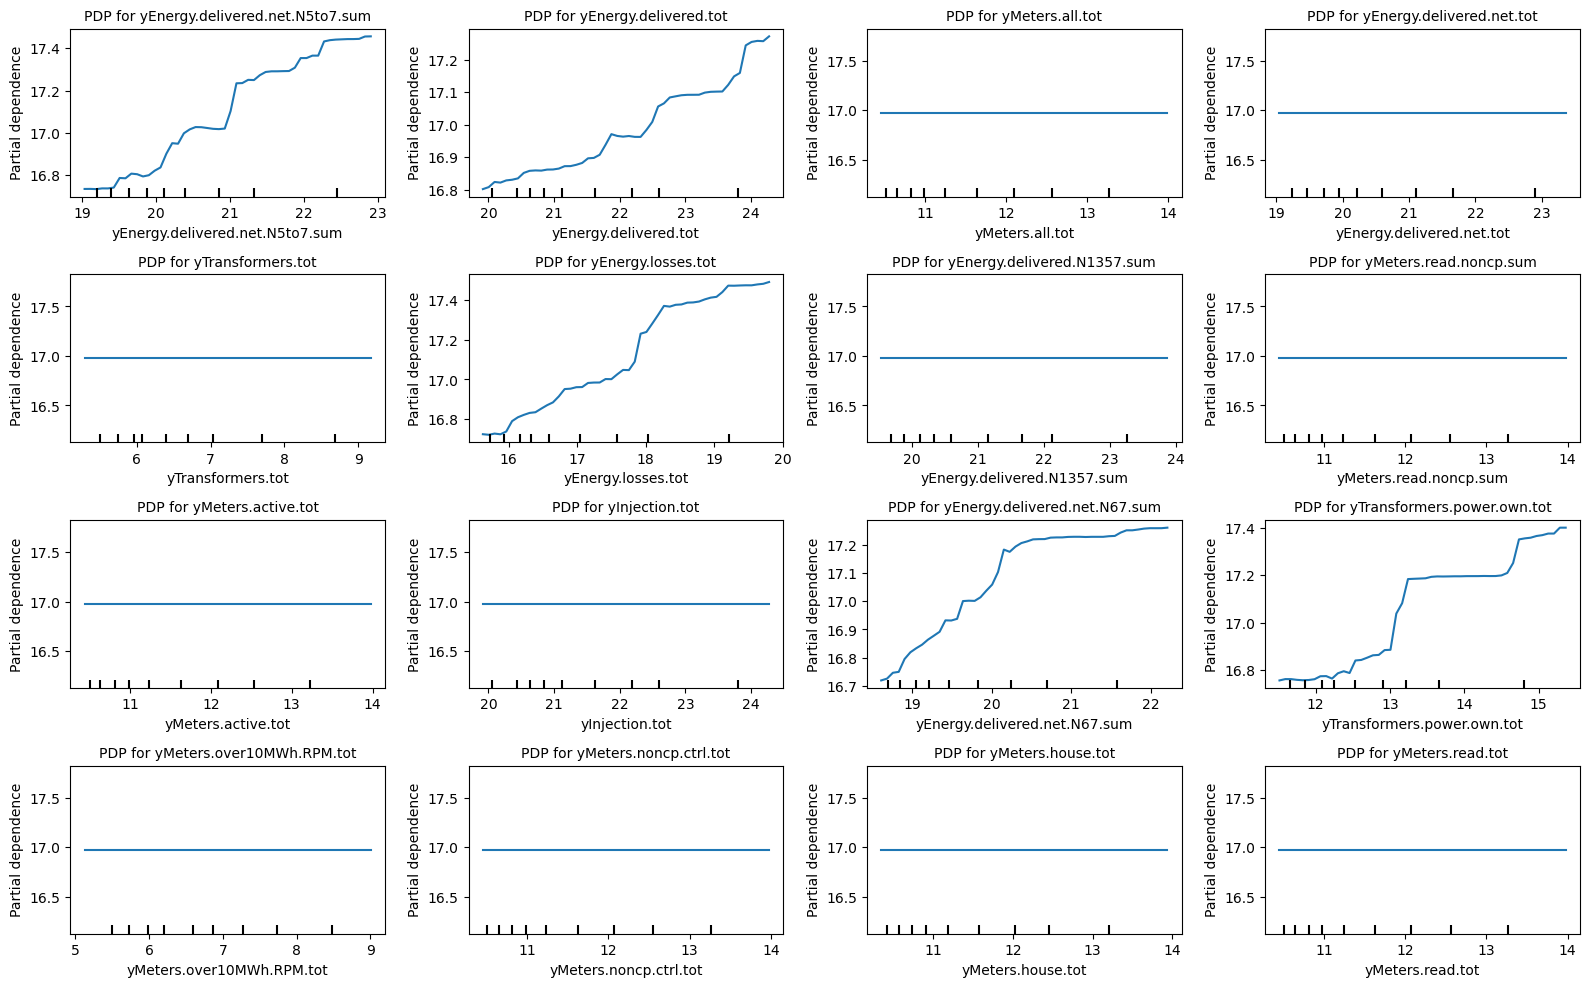

In [307]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", message="Attempting to set identical low and high ylims")


X_train = df_train.drop(columns=["cTOTEXn_log"])

# list of features excluding the empty columns
features = X_train.columns.tolist()
features = [feature for feature in features if feature not in ["empty_1", "empty_2", "empty_3", "empty_4"]]

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 12))
ax = ax.flatten()  # flatten the axes array for easy iteration

# plot PDP for each feature
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        final_rf_agg_log_models[0],
        X_train,
        [feature],
        ax=ax[i],
        grid_resolution=50  #
    )
    ax[i].set_title(f'PDP for {feature}', fontsize=10)

# delete remaining axes
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout() 
plt.show()


The PDP for the features generally increases, implying a positive relationship and adhering to monotonicity constraints.
A limitation is that PDPs reflect the marginal effect of a feature on the target variable, averaged over the distribution of other features. They do not directly give us the regression coefficients or correlations, which are direct indicators of sign.

## Decision Tree

In [350]:
final_dt_baseline_results = pd.DataFrame(columns=columns)
final_dt_baseline_models = []
final_dt_baseline_vips = []

for random_state in random_states:
    df_train, df_test = prepare_base_data(df, random_state = random_state)
    df_train_list, df_test_list = create_variations(df_train, df_test)

    i = 0
    selected_columns = list(dt_baseline_stable) + [outcome_variables[i]]
    
    # due to max_features set in the model definition we fill up blank columns
    df_train = df_train_list[i].copy()[selected_columns]
    df_test = df_test_list[i].copy()[selected_columns]
    
    for index in range(18):
        df_train[f'empty_{index+1}'] = 0
        df_test[f'empty_{index+1}'] = 0

    dt_result, dt_model, dt_vip = decision_tree_regression(df_train, df_test, outcome_variables[i], f"Decision Tree {names[i]}", outcome_transformation = outcome_transformation[i], random_state = random_state)
    final_dt_baseline_results = pd.concat([final_dt_baseline_results, dt_result], axis=0, ignore_index=True)
    final_dt_baseline_models.append(dt_model)
    final_dt_baseline_vips.append(dt_vip)

final_dt_baseline_results.loc[:, final_dt_baseline_results.columns != 'Model'] = final_dt_baseline_results.loc[:, final_dt_baseline_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')
final_dt_baseline_results_df = final_dt_baseline_results.groupby(by = "Model").mean().reset_index().sort_values(by = "Testing MAPE")
final_dt_baseline_results_df


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Decision Tree Baseline,10761135.4580,2706912.9480,0.0420,37016309.6980,13266894.6720,0.2920


In [358]:
final_dt_baseline_models[0].get_params()

{'memory': None,
 'steps': [('feature_selection',
   SelectFromModel(estimator=DecisionTreeRegressor(random_state=39),
                   max_features=20)),
  ('dt', DecisionTreeRegressor(max_depth=20, random_state=39))],
 'verbose': False,
 'feature_selection': SelectFromModel(estimator=DecisionTreeRegressor(random_state=39),
                 max_features=20),
 'dt': DecisionTreeRegressor(max_depth=20, random_state=39),
 'feature_selection__estimator__ccp_alpha': 0.0,
 'feature_selection__estimator__criterion': 'squared_error',
 'feature_selection__estimator__max_depth': None,
 'feature_selection__estimator__max_features': None,
 'feature_selection__estimator__max_leaf_nodes': None,
 'feature_selection__estimator__min_impurity_decrease': 0.0,
 'feature_selection__estimator__min_samples_leaf': 1,
 'feature_selection__estimator__min_samples_split': 2,
 'feature_selection__estimator__min_weight_fraction_leaf': 0.0,
 'feature_selection__estimator__random_state': 39,
 'feature_selection__e

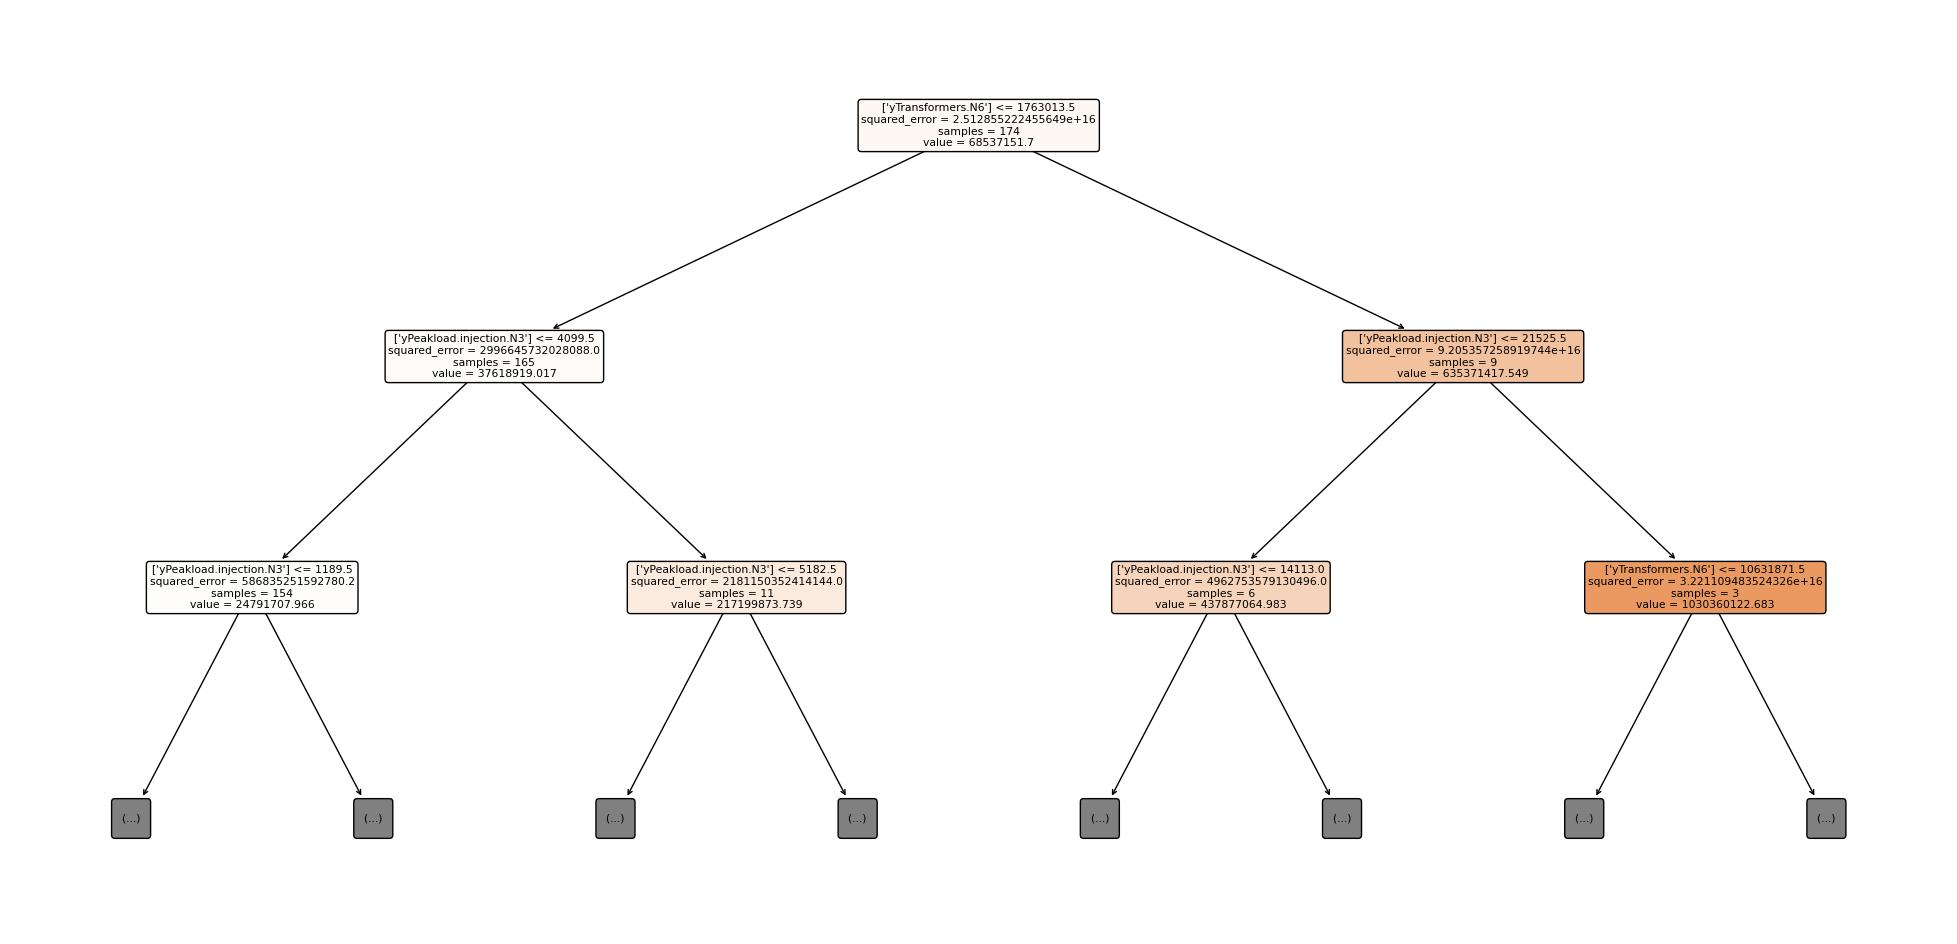

In [345]:
from sklearn.tree import plot_tree

decision_tree_model = final_dt_baseline_models[0].named_steps['dt']
plt.figure(figsize=(25, 12))  # Adjust the figure size for better readability
plot_tree(decision_tree_model, filled=True, feature_names=final_dt_baseline_vips[0][["Feature"]].values.tolist(), rounded=True, max_depth=2)
plt.show()

## Summary Results

In [363]:
# full tablle
final_combined_all = pd.concat([final_lasso_xy_log_results_df, final_lasso_agg_log_results_df, final_lr_xy_log_results_df, final_lr_agg_log_results_df, final_rf_agg_log_results_df, final_dt_baseline_results_df], axis=0)
final_combined_all.sort_values(by=["Testing MAPE", "Testing RMSE"], ascending=True)

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Linear Regression XLog YLog,17041001.7740,7086153.0540,0.1220,11235320.2080,5487740.7340,0.1260
0,Lasso XLog YLog,18722158.0020,7340288.0920,0.1260,9596175.5220,4991840.8700,0.1280
0,Linear Regression Aggregates Only YLog,16014603.3220,6681713.6860,0.1240,10090748.0360,5363045.3520,0.1320
0,Lasso Aggregates Only YLog,17808874.6440,7095395.6540,0.1260,10334888.5000,5419544.5340,0.1380
0,Random Forest Aggregates Only YLog,16906286.3260,4400815.3320,0.0600,29728127.4380,10183473.8060,0.1800
0,Decision Tree Baseline,10761135.4580,2706912.9480,0.0420,37016309.6980,13266894.6720,0.2920
